In [1]:
# Import packages
import pandas as pd
#import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.plotting import plot_decision_regions
import pickle
%matplotlib inline
# make prettier plots
%config InlineBackend.figure_format = 'svg' 

# Class balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline, make_pipeline

# # Modeling
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Yellowbrick visuals-- used for model selection + metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('/Users/alentersakyan/Desktop/Metis/Project_3/Marketing.csv')
df.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,2013-09-09,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,2012-11-13,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,2013-05-08,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,...,20,1,0,0,0,0,0,3,11,0


## Pandas profile report for EDA

In [3]:
#pd.read_csv('/Users/alentersakyan/Desktop/Project_3/Marketing.csv').profile_report()

# Cleaning + EDA

In [4]:
# Drop cols I won't use for sure
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

## Get age

In [5]:
# Get age from dob
def getage(year_birth_col):
    return pd.to_datetime('2015-01').year - year_birth_col

In [6]:
df['Age'] = df['Year_Birth'].apply(getage)

In [7]:
df.Age.describe()

count    2240.000000
mean       46.194196
std        11.984069
min        19.000000
25%        38.000000
50%        45.000000
75%        56.000000
max       122.000000
Name: Age, dtype: float64

# Examine AcceptedCmp_ features

In [8]:
df[df['AcceptedCmp1'] == 1].describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
count,144.000000,144.000000,142.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,...,144.000000,144.000000,144.000000,144.000000,144.000000,144.0,144.000000,144.0,144.000000,144.000000
mean,5324.493056,1968.534722,78872.626761,0.090278,0.215278,46.979167,758.604167,55.847222,433.638889,91.861111,...,8.062500,3.534722,0.166667,0.326389,0.472222,1.0,0.090278,0.0,0.548611,46.465278
std,3078.326355,13.530547,11337.015726,0.332677,0.445069,28.380647,333.571922,55.342079,263.292935,73.293892,...,2.699958,2.044653,0.373979,0.470528,0.500970,0.0,0.287580,0.0,0.499368,13.530547
min,146.000000,1944.000000,37929.000000,0.000000,0.000000,1.000000,152.000000,0.000000,21.000000,0.000000,...,4.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,21.000000
25%,2793.750000,1957.000000,73065.000000,0.000000,0.000000,25.000000,502.000000,19.750000,196.000000,32.000000,...,6.000000,2.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000,36.000000
50%,4901.500000,1969.500000,79967.000000,0.000000,0.000000,45.500000,761.500000,29.500000,437.500000,76.000000,...,8.000000,3.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,1.000000,45.500000
75%,7896.750000,1979.000000,85663.750000,0.000000,0.000000,71.250000,1006.750000,87.750000,614.750000,146.250000,...,10.000000,5.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.0,1.000000,58.000000
max,10965.000000,1994.000000,105471.000000,2.000000,2.000000,99.000000,1493.000000,190.000000,974.000000,253.000000,...,13.000000,9.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.0,1.000000,71.000000


# Create feature for total number of offers used (1-5) before the current

In [9]:
df['total_accepted_offers'] = df.AcceptedCmp1 + df.AcceptedCmp2 + df.AcceptedCmp3 + df.AcceptedCmp4 + df.AcceptedCmp5

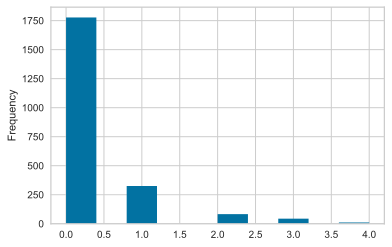

In [12]:
df['total_accepted_offers'].plot(kind='hist')

# Examine NumDealsPurchase + Purchase by location

In [13]:
df['NumDealsPurchases'].describe()

count    2240.000000
mean        2.325000
std         1.932238
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64

In [14]:
df['NumWebPurchases'].describe()

count    2240.000000
mean        4.084821
std         2.778714
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: NumWebPurchases, dtype: float64

In [15]:
df['NumCatalogPurchases'].describe()

count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        28.000000
Name: NumCatalogPurchases, dtype: float64

In [16]:
df['NumStorePurchases'].describe()

count    2240.000000
mean        5.790179
std         3.250958
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        13.000000
Name: NumStorePurchases, dtype: float64

# Web traffic flow

In [18]:
df['NumWebVisitsMonth'].describe()

count    2240.000000
mean        5.316518
std         2.426645
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: NumWebVisitsMonth, dtype: float64

In [19]:
gb_webvisits = df.groupby('NumWebVisitsMonth')

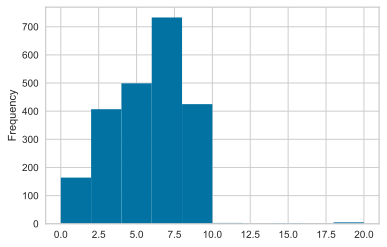

In [20]:
df.NumWebVisitsMonth.plot(kind='hist', bins=10)

## Remove excess features not removed at start

In [22]:
df.drop(['ID', 'Year_Birth'], axis=1, inplace=True)
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'total_accepted_offers'],
      dtype='object')

# Further feature engineering/cleaning

### Education Cleaning/Renaming
- Reduce number of types to help with dumny coding

In [23]:
df['Education'].value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [24]:
# Group a few to HigherEd
df['Education'].rename({"2n Cycle": "HigherEd", "Master": "HigherEd", "PhD": "HigherEd"},inplace=True)

edu_dict = {'HigherEd': ['2n Cycle', 'Master', 'PhD']}
dict2 = {i : k for k, v in edu_dict.items() for i in v}

df['Education'].replace(dict2, inplace=True)

# Education dummy
df = pd.get_dummies(df, columns=['Education'], drop_first = True)

### Income Cleaning

In [25]:
df['Income'].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [39]:
# Remove those with income over 3 stdv
df = df[df['Income'] < (df['Income'].mean() + 3*df['Income'].std())]

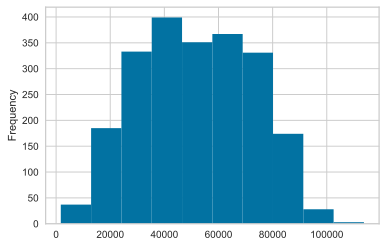

In [40]:
df['Income'].plot(kind='hist')

In [41]:
df['Income'].fillna(df['Income'].median())

0       58138.0
1       46344.0
2       71613.0
3       26646.0
4       58293.0
         ...   
2235    61223.0
2236    64014.0
2237    56981.0
2238    69245.0
2239    52869.0
Name: Income, Length: 2208, dtype: float64

### Kid at home Cleaning
- Combine 1/2 into 1. Having a kid or not.

In [43]:
df['Kidhome'].value_counts()

0    1278
1     884
2      46
Name: Kidhome, dtype: int64

In [44]:
df['Kidhome'].replace(2,1,inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Marital Status
- Combine random values like "YOLO" to "Single"

In [46]:
df['Marital_Status'].value_counts()

Married     854
Together    569
Single      471
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [47]:
df['Marital_Status'].replace('Alone', 'Single', inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [48]:
df['Marital_Status'].replace('YOLO', 'Single', inplace=True)

In [49]:
df['Marital_Status'].replace('Absurd', 'Single', inplace=True)

In [50]:
df['Marital_Status'].replace('Divorced', 'OnceMarried', inplace=True)
df['Marital_Status'].replace('Widow', 'OnceMarried', inplace=True)

In [51]:
# Get dummies, drop first (married)... Make sure to be clear on this interpretation later..
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first = True)

### Teen at home
- Combine 1/2

In [52]:
df['Teenhome'].value_counts()

0    1141
1    1016
2      51
Name: Teenhome, dtype: int64

In [53]:
df['Teenhome'].replace(2,1,inplace=True)

### Amt Purchased
- Examine ammount purchased by category

In [54]:
df.MntWines.describe()

count    2208.000000
mean      306.100996
std       337.516270
min         0.000000
25%        24.000000
50%       177.500000
75%       507.000000
max      1493.000000
Name: MntWines, dtype: float64

In [55]:
df.MntFishProducts.describe()

count    2208.000000
mean       37.758605
std        54.813323
min         0.000000
25%         3.000000
50%        12.000000
75%        50.000000
max       259.000000
Name: MntFishProducts, dtype: float64

In [56]:
df.MntFruits.describe()

count    2208.000000
mean       26.435236
std        39.842478
min         0.000000
25%         2.000000
50%         8.000000
75%        33.000000
max       199.000000
Name: MntFruits, dtype: float64

In [57]:
df.MntMeatProducts.describe()

count    2208.000000
mean      165.347826
std       217.852649
min         0.000000
25%        16.000000
50%        68.000000
75%       232.000000
max      1725.000000
Name: MntMeatProducts, dtype: float64

In [58]:
df.MntSweetProducts.describe()

count    2208.000000
mean       27.122283
std        41.116999
min         0.000000
25%         1.000000
50%         8.000000
75%        34.000000
max       262.000000
Name: MntSweetProducts, dtype: float64

### Date they became a customer-- translate to years since today

In [59]:
df.Dt_Customer = pd.to_datetime(df.Dt_Customer)

In [60]:
df.Dt_Customer

0      2012-09-04
1      2014-03-08
2      2013-08-21
3      2014-02-10
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-06-10
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: Dt_Customer, Length: 2208, dtype: datetime64[ns]

In [61]:
# Get length of being a customer (from dt_customer - 2015-01)
def getCustomerLength(customer_length_col):
    return pd.to_datetime('2015-01') - customer_length_col

In [62]:
df['CustomerLength'] = df['Dt_Customer'].apply(getCustomerLength)

# Convert to days
import datetime as dt
df['CustomerLength'] = df['CustomerLength'].dt.days

## Compute variable for total revenue in last 2 years

In [63]:
df['TotalRevenueFoodItems'] = df['MntFishProducts'] + df['MntFruits'] + df[
    'MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']
df['TotalRevenueFoodItems']

0       1529
1         21
2        734
3         48
4        407
        ... 
2235    1094
2236     436
2237    1217
2238     782
2239     151
Name: TotalRevenueFoodItems, Length: 2208, dtype: int64

In [64]:
df.drop('Complain', axis =1 , inplace=True)

In [65]:
df.drop('Dt_Customer', axis=1, inplace=True)

## Final df, pickle

In [66]:
import pickle
with open ('df_cleaned.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# # To load pickle back in
# with open('df_cleaned.pickle','rb') as read_file:
#       df = pickle.load(read_file)

# Base Models
- Must train/test split THEN balance classes

In [67]:
with open('df_cleaned.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

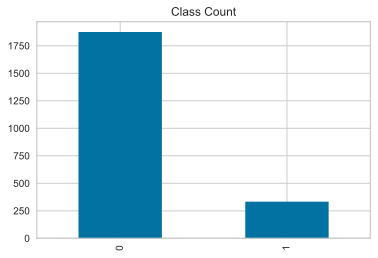

In [68]:
# Check class imbalance
df.Response.value_counts().plot(kind='bar', title= "Class Count");

## Train/test split

In [69]:
# create IV/DV variables
y = df['Response']
X = df.drop('Response', axis=1)

In [70]:
# Train test split, stratify = y to make sure classes split evenly across train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state=4, stratify=y)

## Resampling-- oversampling minority

In [71]:
# KFold to standardize splits
kf = KFold(n_splits=5, random_state=4, shuffle=False)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## Begin exploratory pipelines
- Pipelines with base parameters to see which classifier might be the best for the data
- Will fine tune the best later
- All based off of imba pipeline that does CV and upsampling in pipe


In [78]:
# Hyperparams for each of these will be tuned using GridSearchCV later

# Classifiers list for pipeline
classifiers = [KNeighborsClassifier(5),
              GaussianNB(),
              SVC(kernel='rbf', C=.25, probability=True, gamma='auto'),
              DecisionTreeClassifier(),
              RandomForestClassifier(n_estimators=100),
              LogisticRegression(solver='saga', max_iter=10000)]


In [79]:
def pipeline_with_SMOTE(classifiers):
    '''Pipeline that does crossval and balances. Only balances the train part of the CV, not the test.\
    Prints out metrics. This is used for model selection. Best models will be tuned later'''
    for classifier in classifiers:
        pipeline_with_SMOTE = make_pipeline(SMOTE(random_state=4),classifier)
        
        # Print various scoring metrics
        print("Metrics for model: {}".format(classifier))
        print("crossval train accuracy score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring = 'accuracy').mean()))
        print("crossval train recall score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring='recall').mean()))
        print("crossval train precision score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring='precision').mean()))
        print("crossval train f1 score: {}".format(cross_val_score(pipeline_with_SMOTE,X_train,y_train,cv=kf, scoring='f1').mean()))


In [80]:
pipeline_with_SMOTE(classifiers)

Metrics for model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
crossval train accuracy score: 0.6936620732702742
crossval train recall score: 0.5658703288313836
crossval train precision score: 0.2617529459621881
crossval train f1 score: 0.3564470817443969
Metrics for model: GaussianNB(priors=None, var_smoothing=1e-09)
crossval train accuracy score: 0.7276372017093197
crossval train recall score: 0.5419313155590286
crossval train precision score: 0.28531162371028657
crossval train f1 score: 0.37333452590135907
Metrics for model: SVC(C=0.25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
crossval train accuracy score: 0.8510651237976345
crossval train recall sc

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


crossval train precision score: 0.4
crossval train f1 score: 0.02169312169312169
Metrics for model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
crossval train accuracy score: 0.8069173028600695
crossval train recall score: 0.5220826270120105
crossval train precision score: 0.39886384279893505
crossval train f1 score: 0.4452074291300098
Metrics for model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.

In [81]:
def pipeline_with_ADASYN(classifiers):
    '''Pipeline that does crossval and balances. Only balances the train part of the CV, not the test.\
    Prints out metrics. This is used for model selection.'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        # Print various scoring metrics
        print("Metrics for model: {}".format(classifier))
        print("crossval train accuracy score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring = 'accuracy').mean()))
        print("crossval train recall score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring='recall').mean()))
        print("crossval train precision score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring='precision').mean()))
        print("crossval train f1 score: {}".format(cross_val_score(pipeline_with_ADASYN,X_train,y_train,cv=kf, scoring='f1').mean()))


In [82]:
pipeline_with_ADASYN(classifiers)

Metrics for model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
crossval train accuracy score: 0.672138730173973
crossval train recall score: 0.5655733236337925
crossval train precision score: 0.2464446345086142
crossval train f1 score: 0.3425554796956408
Metrics for model: GaussianNB(priors=None, var_smoothing=1e-09)
crossval train accuracy score: 0.7316016068884941
crossval train recall score: 0.5611034288487888
crossval train precision score: 0.2929972446432624
crossval train f1 score: 0.38451053756559056
Metrics for model: SVC(C=0.25, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
crossval train accuracy score: 0.7019093804516572
crossval train recall scor

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


crossval train precision score: 0.22598870056497175
crossval train f1 score: 0.0534074074074074
Metrics for model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
crossval train accuracy score: 0.8114274739520815
crossval train recall score: 0.4792155801929888
crossval train precision score: 0.38016221221700675
crossval train f1 score: 0.43308747140751125
Metrics for model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impu

# Visuals for base models (with ADASYN)
- The functions below will produce visuals for each model to help evaluate thresholds + model selection
- Learning Curve, PR curve, Discrimination Threshold, Conf Matrix

In [83]:
def pipeline_with_ADASYN_LCurve(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out visuals for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        # Learning Curve 
        train_sizes, train_scores, test_scores = learning_curve(pipeline_with_ADASYN, X_train, y_train, cv=kf)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        # Plot Learning Curve
        plt.figure()
        plt.title("plotting learning curve for: {}".format(pipeline_with_ADASYN))
        # if ylim is not None:
        #     plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        plt


In [84]:
# Below with learning curve for base models
# pipeline_with_ADASYN_LCurve(classifiers)

In [87]:
def pipeline_with_ADASYN_PRCurve(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out Precision-Recall curve plot for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        # Precision-Recall Curve Plot
        viz = PrecisionRecallCurve(classifier)
        viz.fit(X_train, y_train)
        viz.score(X_test, y_test)
        viz.show()

#         precision_curve, recall_curve, threshold_curve = precision_recall_curve\
#     (y_test, pipeline_with_SMOTE.predict_proba(X_test)[:,1])
#     plt.figure(dpi=80)
#     plt.plot(threshold_curve, precision_curve[1:],label='precision')
#     plt.plot(threshold_curve, recall_curve[1:], label='recall')
#     plt.legend(loc='lower left')
#     plt.xlabel('Threshold (above this probability, label as fraud)');
#     plt.title('Precision and Recall Curves');

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


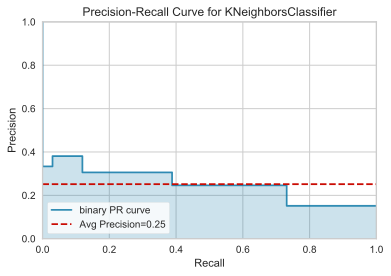

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


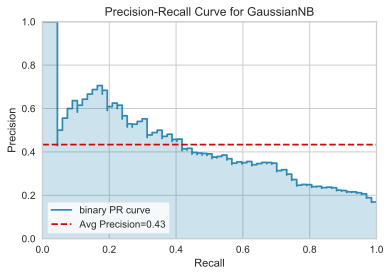

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


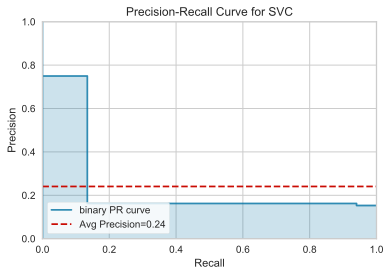

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


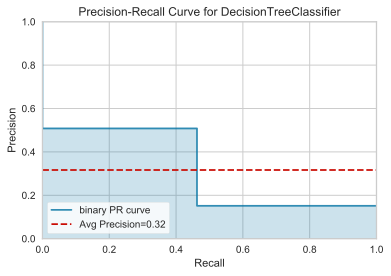

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


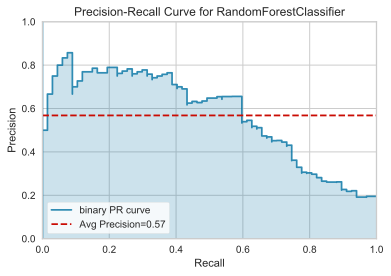

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


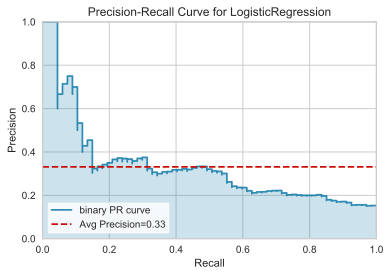

In [88]:
pipeline_with_ADASYN_PRCurve(classifiers)

In [89]:
def pipeline_with_ADASYN_DiscrimThresh(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out discrimination threshold plot for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        # Discrimination Threshold Plot
        model = pipeline_with_ADASYN
        visualizer = DiscriminationThreshold(model)
        visualizer.fit(X_train, y_train)
        visualizer.show()
        

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/a

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

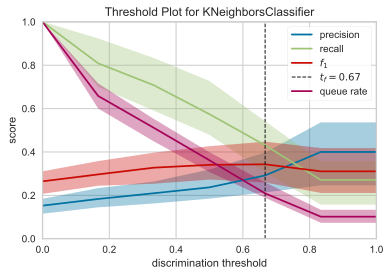

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/a

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

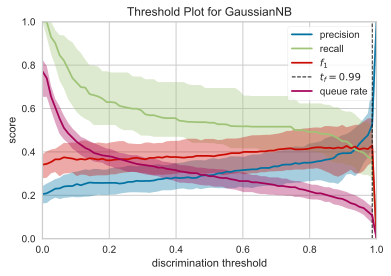

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/a

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

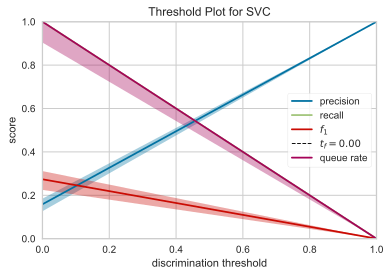

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/a

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

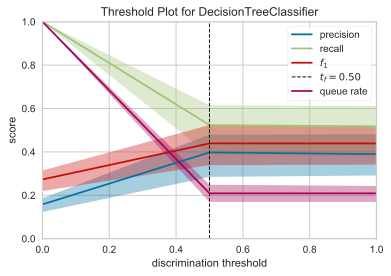

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/a

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

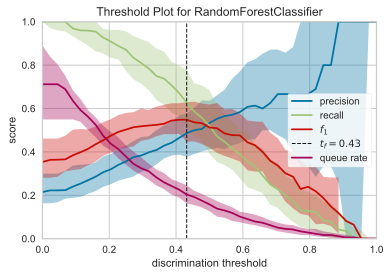

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/a

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

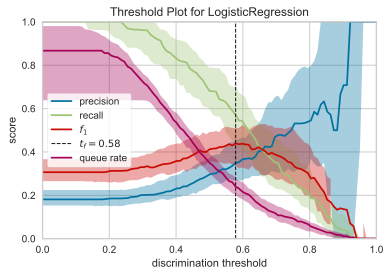

In [90]:
pipeline_with_ADASYN_DiscrimThresh(classifiers)

In [92]:
def pipeline_with_ADASYN_ConfMatrix(classifiers):
    '''Does cross val and models baseline (non hyper tuned) models in classifiers list.\
    Prints out visuals for each model'''
    for classifier in classifiers:
        pipeline_with_ADASYN = make_pipeline(ADASYN(random_state=4),classifier)
        
        confusion = confusion_matrix(y_test, pipeline_with_ADASYN.predict(X_test))
        plt.figure(dpi=90)
        ax = sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True,\
                   xticklabels=[0,1], yticklabels=[0,1])
        bottom,top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion matrix for: {}'.format(pipeline_with_ADASYN))

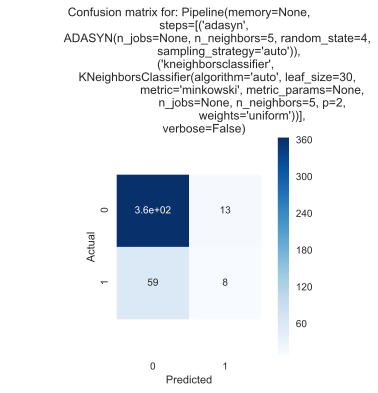

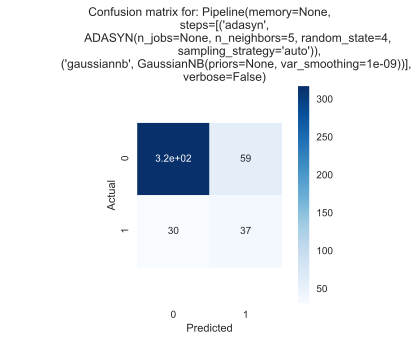

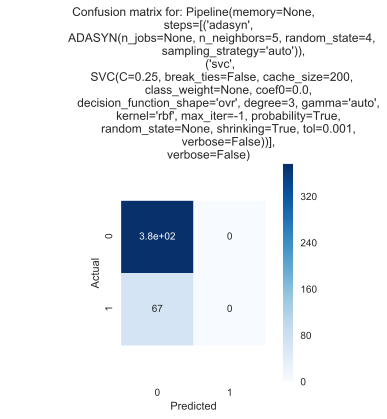

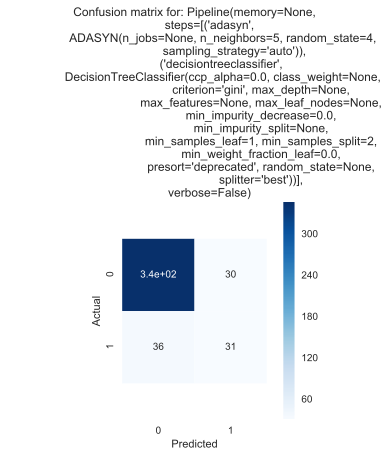

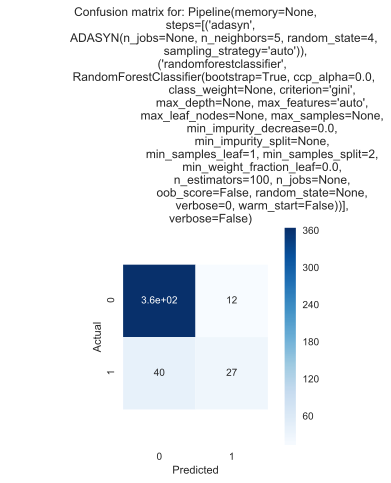

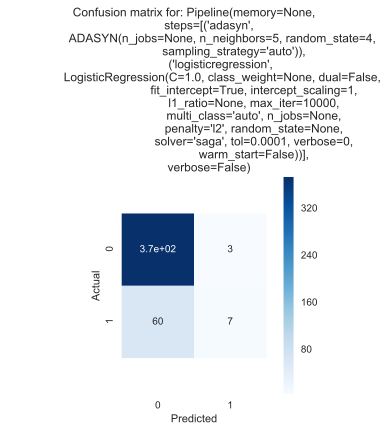

In [93]:
pipeline_with_ADASYN_ConfMatrix(classifiers)

# This is repeated in Top Models so can cut this off when posting






# Grid Search CV on top models: RandomForest + Logistic Regression

In [94]:
top_models = [RandomForestClassifier(),
              LogisticRegression(solver='saga', max_iter=10000)]

## GridSearchCV on RandForest

In [95]:
randforest_pipeline = make_pipeline(ADASYN(random_state=4),RandomForestClassifier())

# Parameters to loop through for RandomForest model
params_randforest = {'n_estimators': [50, 100, 250, 500, 1000, 1500],
          'max_depth': [2, 3],
          'random_state': [4]}

# Prep GridSearchCV
new_params = {'randomforestclassifier__' + key: params_randforest[key] for key in params_randforest}
randforest_pipeline = GridSearchCV(randforest_pipeline, param_grid=new_params, cv=kf, scoring='recall',\
                                   return_train_score=True)

        


In [96]:
randforest_pipeline.fit(X_train, y_train)
print("Random Forest mean test scores: {}".format(randforest_pipeline.cv_results_['mean_test_score']))
print("Random Forest mean train scores: {}".format(randforest_pipeline.cv_results_['mean_train_score']))
print("Random Forest best score: {}".format(randforest_pipeline.best_score_))
print("Random Forest best params: {}".format(randforest_pipeline.best_params_))

Random Forest mean test scores: [0.69249461 0.67870373 0.67352212 0.67786995 0.68479946 0.68109575
 0.70364221 0.67299258 0.6733225  0.6738004  0.6770262  0.6770262 ]
Random Forest mean train scores: [0.74607501 0.72822594 0.72714437 0.7358022  0.73381521 0.73101933
 0.76758664 0.7517127  0.75362506 0.75277573 0.75269483 0.75080092]
Random Forest best score: 0.7036422052480258
Random Forest best params: {'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 4}


In [97]:
# Apply grid search cv results
y_test_predict_randforest = randforest_pipeline.best_estimator_.predict(X_test)
print("Recall for post-gridsearch Random Forest predictions: {}".format(recall_score(y_test, y_test_predict_randforest)))

Recall for post-gridsearch Random Forest predictions: 0.7313432835820896


In [98]:
randforest_pipeline.best_params_

{'randomforestclassifier__max_depth': 3,
 'randomforestclassifier__n_estimators': 50,
 'randomforestclassifier__random_state': 4}

# ROCAUC for post-gridsearch Random Forest

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


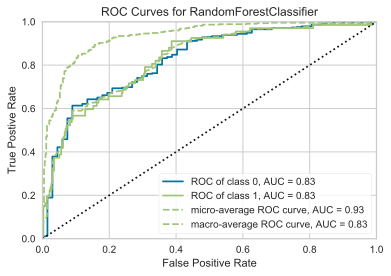

In [99]:
# Instantiate the visualizer with the classification model
model = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=4)
visualizer2 = ROCAUC(model, classes=["0", "1"])

visualizer2.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer2.score(X_test, y_test)        # Evaluate the model on the test data
visualizer2.show();                      # Finalize and show the figure

# Manual / nonpipeline loop testing
- Testing the models outside of the imblearn pipeline to make sure it is working correctly

## Manual logreg (with imba pipeline, just no loop)

In [100]:
logreg_pipeline = make_pipeline(
    ADASYN(random_state=4),
    LogisticRegression(random_state=44, max_iter=10000, solver='saga'))
logreg_pipeline

Pipeline(memory=None,
         steps=[('adasyn',
                 ADASYN(n_jobs=None, n_neighbors=5, random_state=4,
                        sampling_strategy='auto')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=44,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [101]:
cross_val_score(logreg_pipeline, X_train,y_train, scoring='recall', cv=kf)

array([0.67391304, 0.66037736, 0.7254902 , 0.75925926, 0.59677419])

In [102]:
logreg_pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('adasyn',
                 ADASYN(n_jobs=None, n_neighbors=5, random_state=4,
                        sampling_strategy='auto')),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=44,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [103]:
y_predict_logreg = logreg_pipeline.predict(X_test)

# Predict_proba for logreg_pipeline (imbalearn implemented)

In [104]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_train, logreg_pipeline.predict_proba(X_train)[:,1] )
df_logreg_pipe = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),\
                     columns=['precision','recall', 'threshhold'])

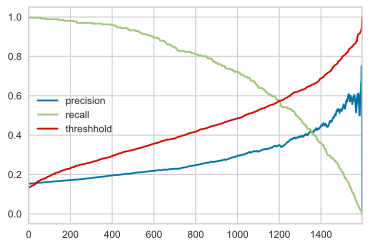

In [105]:
df_logreg_pipe.plot()

## Test precision recall curve for LR manually

In [ ]:
# from sklearn.metrics import precision_recall_curve
# logreg = LogisticRegression()
# logreg.fit(X_train, y_train)
# print("Test set score is {}%".format(100*logreg.score(X_test,y_test)))

# # Metrics for LogReg
# y_predict_randforest = logreg.predict(X_test)

# precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1] )

# df_pr = pd.DataFrame(list(zip(precision_curve, recall_curve, threshold_curve)),
#               columns=['precision','recall', 'threshhold'])
# # print("Random Forest Metrics on Test data:")
# # print("Accuracy is: {}".format(accuracy_score(y_test,y_predict_randforest)))
# # print("Precision is: {}".format(precision_score(y_test,y_predict_randforest)))
# # print("Recall is: {}".format(recall_score(y_test,y_predict_randforest)))
# # print("F1 is: {}".format(f1_score(y_test,y_predict_randforest)))

In [ ]:
# df_pr

In [ ]:
# df_pr.plot()

In [ ]:
# precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, logreg.predict_proba(X_test)[:,1] )

## Testing learning curve + plot for random forest, outside of pipeline loop

In [113]:
# randforest = RandomForestClassifier(n_estimators=100)
# randforest.fit(X_train, y_train)
# print("Test set score is {}%".format(100*randforest.score(X_test,y_test)))

In [114]:
# # Random Forest cross val score
# print(cross_val_score(randforest,X_train,y_train,cv=5).mean())

In [115]:
# # Metrics for Random Forest
# y_predict_randforest = randforest.predict(X_test)
# print("Random Forest Metrics on Test data:")
# print("Accuracy is: {}".format(accuracy_score(y_test,y_predict_randforest)))
# print("Precision is: {}".format(precision_score(y_test,y_predict_randforest)))
# print("Recall is: {}".format(recall_score(y_test,y_predict_randforest)))
# print("F1 is: {}".format(f1_score(y_test,y_predict_randforest)))

In [117]:
# train_sizes2, train_scores2, test_scores2 = learning_curve(
#         randforest, X_train, y_train, cv=5)

# train_scores_mean2 = np.mean(train_scores2, axis=1)
# train_scores_std2 = np.std(train_scores2, axis=1)
# test_scores_mean2 = np.mean(test_scores2, axis=1)
# test_scores_std2 = np.std(test_scores2, axis=1)

# plt.figure()
# plt.title("plotting learning curve")
# # if ylim is not None:
# #     plt.ylim(*ylim)
# plt.xlabel("Training examples")
# plt.ylabel("Score")
# plt.grid()

# plt.fill_between(train_sizes2, train_scores_mean2 - train_scores_std2,
#                     train_scores_mean2 + train_scores_std2, alpha=0.1,
#                     color="r")
# plt.fill_between(train_sizes2, test_scores_mean2 - test_scores_std2,
#                     test_scores_mean2 + test_scores_std2, alpha=0.1, color="g")
# plt.plot(train_sizes2, train_scores_mean2, 'o-', color="r",
#             label="Training score")
# plt.plot(train_sizes2, test_scores_mean2, 'o-', color="g",
#             label="Cross-validation score")

# plt.legend(loc="best")
# plt